In [1]:
from os.path import dirname, abspath,join
from os import makedirs
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.evaluation.predict import *
from proT.evaluation.metrics import *

# plotting standard settings
plt.rcParams['figure.dpi'] = 100 #360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5

S6 Mamba backend: mamba-pytorch (pure PyTorch fallback)


c:\Users\ScipioneFrancesco\Documents\Projects\proT\proT\baseline\s6\s6_wrapper.py:17: UserWarning: Using pure PyTorch implementation of Mamba (slower but functional). For faster performance on GPU clusters, install mamba-ssm with CUDA support: pip install mamba-ssm causal-conv1d
  warnings.warn(


In [2]:


def build_models_sweep_from_baseline_df(df):
    """
    Build models_sweep list from baseline results dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with columns: 'model', 'dataset', 'best_trial'
        where 'best_trial' points to the kfold_summary.json file
    
    Returns:
    --------
    list of dict
        List of dictionaries with keys: 'model', 'config_path', 'checkpoint_path'
    """
    models_sweep = []
    
    for idx, row in df.iterrows():
        model_name = row['model']
        #dataset_name = row['dataset']
        best_trial_path = row['best_trial']
        
        # Create unique model identifier
        model_id = f"{model_name}"#_{dataset_name}"
        
        # Parse the best_trial path to extract components
        # Example: ../experiments/baseline_optuna/euler/baseline_GRU_dyconex_sum_49151758\optuna\run_4\kfold_summary.json
        best_trial_path = best_trial_path.replace('\\', '/')  # Normalize path separators
        
        # Extract base experiment folder
        parts = best_trial_path.split('/')
        
        # Find the index of 'optuna' in the path
        try:
            optuna_idx = parts.index('optuna')
            base_folder_parts = parts[:optuna_idx]
            base_folder = '/'.join(base_folder_parts)
            
            # Extract run folder name (e.g., 'run_4')
            run_folder = parts[optuna_idx + 1]
            
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse path for {model_id}: {best_trial_path}")
            print(f"Error: {e}")
            continue
        
        # Find config file using glob pattern
        config_pattern = os.path.join(base_folder, "config_*.yaml")
        config_files = glob.glob(config_pattern)
        
        if not config_files:
            print(f"Warning: No config file found for {model_id} at {config_pattern}")
            continue
        
        config_path = config_files[0]  # Take first match
        
        # Load kfold_summary.json to get best fold number
        try:
            kfold_summary = OmegaConf.load(best_trial_path)
            best_fold_number = kfold_summary.best_fold.fold_number
        except Exception as e:
            print(f"Warning: Could not load kfold_summary for {model_id}: {e}")
            continue
        
        # Construct checkpoint path
        checkpoint_path = os.path.join(
            base_folder,
            'optuna',
            run_folder,
            f'k_{best_fold_number}',
            'checkpoints',
            'best_checkpoint.ckpt'
        )
        
        # Verify checkpoint exists
        if not os.path.exists(checkpoint_path):
            print(f"Warning: Checkpoint not found for {model_id}: {checkpoint_path}")
            # Try alternative path construction in case of path issues
            checkpoint_path = checkpoint_path.replace('\\', '/')
            if not os.path.exists(checkpoint_path):
                continue
        
        # Add to models_sweep
        models_sweep.append({
            "model": model_id,
            "config_path": config_path,
            "checkpoint_path": checkpoint_path
        })
        
        print(f"Added {model_id}:")
        print(f"  Config: {config_path}")
        print(f"  Checkpoint: {checkpoint_path}")
    
    return models_sweep


## Load Baseline Results

In [6]:
df = pd.read_csv("./output/baseline_results.csv")
df = df.set_index("dataset").loc["ishigami"]
df

,Unnamed: 0,model,test MAE,test R2,average_epoch_training_time,number_trainable_params,best_trial
dataset,,,,,,,
ishigami,1,GRU,0.21+/-0.0,-0.03+/-0.0,5.021374,8581,../experiments/baseline_optuna/euler/baseline_...
ishigami,3,LSTM,0.05+/-0.01,0.91+/-0.04,4.795649,7691,../experiments/baseline_optuna/euler/baseline_...
ishigami,5,proT,0.01+/-0.0,0.99+/-0.0,8.623051,558801,../experiments/baseline_optuna/euler/baseline_...
ishigami,7,TCN,0.17+/-0.0,0.19+/-0.01,111.949902,337409,../experiments/baseline_optuna/euler/baseline_...


In [7]:
models_sweep = build_models_sweep_from_baseline_df(df)
datadir_path = "../data/input"

blank_vector = [0, 0.2, 0.4]


df_tot = None

for model_dict in models_sweep:
    
    # unpack
    model           = model_dict["model"]
    config_path     = model_dict["config_path"]
    checkpoint_path = model_dict["checkpoint_path"]

    config = OmegaConf.load(config_path)
    df_blank = None

    for blank_val in blank_vector:

        if blank_val == 0:
            blanking_fn = None
        else:
            # Create blanking function with current blanking
            blanking_fn = create_input_blanking_fn(
                beta=blank_val,
                val_idx=config["data"]["val_idx"],
                seed=42  # Reproducible
            )

        results = predict_test_from_ckpt(config, datadir_path, checkpoint_path, input_conditioning_fn=blanking_fn)
        metrics_df = compute_prediction_metrics(results, target_feature_idx=config["data"]["val_idx"])

        metrics_df["Blanking"] = blank_val

        if df_blank is None:
            df_blank = metrics_df
        else:
            df_blank = pd.concat([df_blank,metrics_df], ignore_index=True)
    
    df_blank["Model"] = model
    if df_tot is None:
        df_tot = df_blank
    else:
        df_tot = pd.concat([df_tot, df_blank], ignore_index=True)

Seed set to 42


Added GRU:
  Config: ../experiments/baseline_optuna/euler/baseline_GRU_ishigami_sum_49153031\config_RNN_v1-0-0_ishigami.yaml
  Checkpoint: ../experiments/baseline_optuna/euler/baseline_GRU_ishigami_sum_49153031\optuna\run_2\k_2\checkpoints\best_checkpoint.ckpt
Added LSTM:
  Config: ../experiments/baseline_optuna/euler/baseline_LSTM_ishigami_sum_49194971\config_RNN_v1-0-0_ishigami.yaml
  Checkpoint: ../experiments/baseline_optuna/euler/baseline_LSTM_ishigami_sum_49194971\optuna\run_6\k_1\checkpoints\best_checkpoint.ckpt
Added proT:
  Config: ../experiments/baseline_optuna/euler/baseline_proT_ishigami_sum_49228236\config_proT_ishigami_v5_2.yaml
  Checkpoint: ../experiments/baseline_optuna/euler/baseline_proT_ishigami_sum_49228236\optuna\run_5\k_1\checkpoints\best_checkpoint.ckpt
Added TCN:
  Config: ../experiments/baseline_optuna/euler/baseline_TCN_ishigami_sum_49291565\config_TCN_v1-0-0_ishigami.yaml
  Checkpoint: ../experiments/baseline_optuna/euler/baseline_TCN_ishigami_sum_49291565\o

100%|██████████| 64/64 [00:04<00:00, 14.13it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:04<00:00, 13.83it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:04<00:00, 14.10it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:04<00:00, 13.89it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:05<00:00, 11.99it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:05<00:00, 11.97it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:05<00:00, 11.50it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:06<00:00, 10.36it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:24<00:00,  2.60it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:07<00:00,  8.95it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:05<00:00, 12.19it/s]
Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Loading pre-split data.
Train input shape:  (12789, 20, 5)
Train target shape:  (12789, 1, 4)
Test input shape:  (3211, 20, 5)
Test target shape:  (3211, 1, 4)
Test dataset selected.
Predicting...


100%|██████████| 64/64 [00:05<00:00, 11.96it/s]


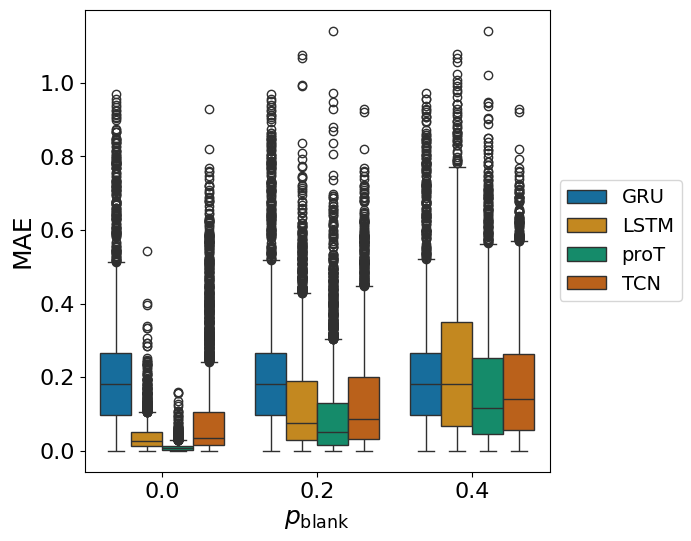

In [8]:
import seaborn as sns


fig, ax = plt.subplots()

sns.boxplot(df_tot, x="Blanking", y="MAE", hue="Model", ax=ax, palette="colorblind")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r"$p_\text{blank}$")

# export
filename = f"blanking.pdf"
save_dir = "./figures"
if save_dir is not None:
    makedirs(save_dir, exist_ok=True)
    out_path = join(save_dir, filename)
    fig.savefig(out_path, format="pdf", bbox_inches="tight")
        
plt.show()